In [33]:
import sys
if ".." not in sys.path:
    sys.path.append("..")

In [34]:
import os
import numpy as np
import torch
import proplot as pplt
import matplotlib.pyplot as plt
import torch.nn.functional as F
from mpl_toolkits.basemap import Basemap
import baselines
import utils
import pandas as pd

In [35]:
dev = "cuda" if torch.cuda.is_available() else "cpu"
pi, pj = 48, 195
ext = [-135.0, 20.0, -60.0, 52.0]
lon = ext[0] + (pj / 256) * (ext[2] - ext[0])
lat = ext[3] - (pi / 128) * (ext[3] - ext[1])
grads = []
b = 0
smoothing = 1
fig, axs = pplt.subplots([[1, 2, 3], [4, 5, 0]], share=False)
# ts = np.arange(180)
# ts = np.array([0])
ts = np.linspace(0, 179, 12, dtype=int)

for depth in range(5):
    C, _, Y, M  = utils.load_training_data(
        "../data/training_data.pkl", standardize_weather=True, log_so4=False,
        standardize_so4=True, year_averages=False, remove_zeros=True
    )
    ax = axs[depth]
    ckptdir = f"../results/time_reg/depth{depth + 1}/checkpoints/"
    ckpt = f"{ckptdir}/{sorted(os.listdir(ckptdir))[-1]}"
    model = baselines.UNetRegression.load_from_checkpoint(ckpt).to(dev)

    # add time to C (the treatment here)
    nt, nd, nr, nc = C.shape
    if model._hparams["add_time"]:
        time = np.zeros((nt, 2, nr, nc))
        for i in range(nr):
            for j in range(nc):
                time[:, 0, i, j] = np.arange(nt) // 12
                time[:, 1, i, j] = np.arange(nt) % 12
        C = np.concatenate([C, time], axis=1)
        nd += 2

    C = torch.FloatTensor(C).to(dev)[ts]
    Y = torch.FloatTensor(Y).to(dev)[ts]
    M = torch.FloatTensor(M).to(dev)[ts]
    C.requires_grad_(True)
    g = torch.zeros_like(Y)
    g[..., (pi-b):(pi+b+1), (pj-b):(pj+b+1)] = 1
    out = model(C)
    out.backward(gradient=g)
    grad = C.grad
    K = torch.ones((1, 1, smoothing, smoothing), device=dev)
    grad = torch.cat(
        [F.conv2d(grad[:, j].view(-1, 1, nr, nc), K, padding='same') for j in range(nd)],
        axis=1
    )
    grad = grad.norm(2, dim=1)
    grad = grad.mean(0)
    l, u = grad[M[0] > 0].amin(), grad[M[0] > 0].amax()
    grad = (grad - l) / (u - l)
    grad = grad.cpu().numpy()
    m = Basemap(projection="cyl", *ext, ax=ax)
    m.drawcoastlines(0.5)
    m.drawstates(0.05)
    m.drawcountries(0.15)
    ax.set_xlim(-100.0, -63.0)
    # ax.set_ylim(25.0, 50.0)
    ax.scatter(lon, lat, c="blue", m=".", s=50)
    mask = M[0].cpu().numpy()
    m.imshow(grad[::-1] * mask[::-1], vmin=0.0, vmax=1.0)

plt.savefig("../figures/depth-performance2.png", bbox_inches="tight")


Text(0, 0.5, 'Explained variance')

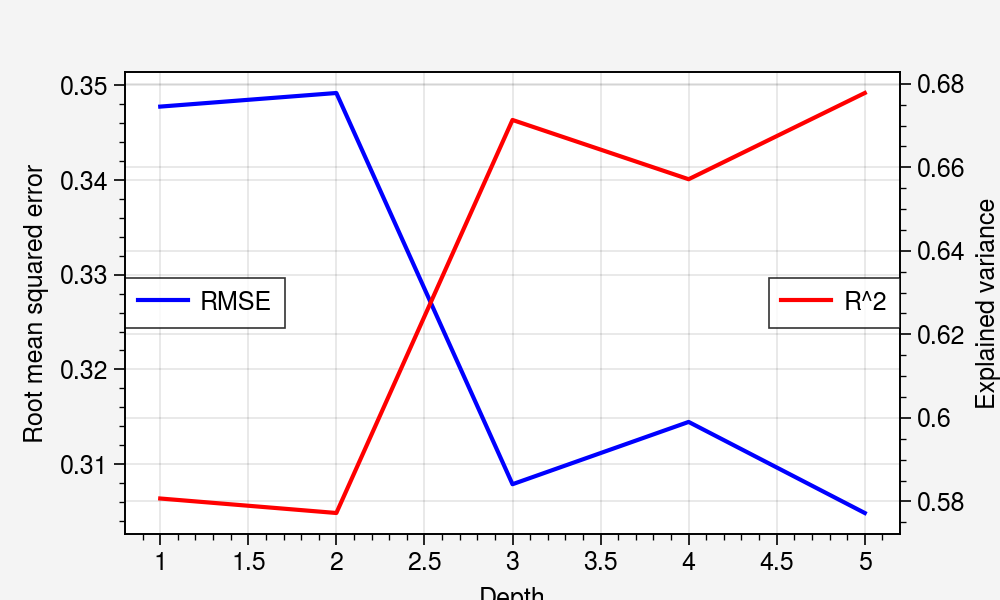

In [ ]:
fix, ax = plt.subplots(figsize=(5, 3))
tail = 10

df = []
for d in range(5):
    dfd = pd.read_csv(f"../results/time_reg/depth{d + 1}/metrics.csv")
    dfd = dfd[~np.isnan(dfd.vloss)].copy()
    dfd.iloc[-tail:]
    dfd["depth"] = d + 1
    df.append(dfd)
df = pd.concat(df)
df = df.groupby("depth").agg(dict(vloss='mean', vr2='mean')).reset_index()
ax.plot(list(range(1, 6)), np.sqrt(df.vloss), label="RMSE", c="blue")
ax1 = ax.twinx()
ax1.plot(list(range(1, 6)), df.vr2, label="R^2", c="red")
ax.set_xlabel("Depth")
ax.legend(loc="center left")
ax1.legend(loc="center right")
ax.set_ylabel("Root mean squared error")
ax1.set_ylabel("Explained variance")
